# PVGeo-Discretize

This notebook demonstrates how to pair `PVGeo` and `discretize` for simple processing routines. 

This notebook is outlined into four sections:

1. Introduction to PVGeo
2. Overview of new VTK interface in `discretize`
3. Pairing PVGeo and `discretize`
4. Examples of PVGeo in ParaView

### DISCLAIMER

This will only work off of a development branch of `discretize` at this time

In [1]:
%matplotlib notebook
import discretize
import PVGeo
import numpy as np
import vtk

## 1. Introduction to PVGeo

### What is PVGeo?

- **Python** package for 3D/4D geovisualization.
- Create compelling and **integrated visualizations**.
- Built upon **VTK**, a scalable and well-maintained visualization library.
- Extends geovisualization into **ParaView**, **VTK.js**, and **Virtual Reality**.
- **Open-source** and automatically deployed.

![expansion-diagram](./images/expansion-diagram.png)


### Abstract

PVGeo is an open-source Python package for geoscientific visualization and analysis, harnessing an already powerful software platform: the Visualization Toolkit (VTK) and its front-end application, [ParaView](http://paraview.org). The VTK software platform is well-maintained, contains an expansive set of native functionality, and provides a robust foundation for scientific visualization, yet the development of tools compatible for geoscience data and models has been limited. As a software extension package to VTK and ParaView, PVGeo addresses the lack of geoscientific compatibility by creating a framework for geovisualization. This framework is a set of tools for visually integrating geoscience data and models directly within ParaView's graphical user interface, simplifying the required routines to make compelling visualizations of geoscientific datasets. PVGeo aims to make the process of importing data into ParaView simple and fluid for users while providing a guide for contributions avoiding the typical, ambitious programming endeavor of building ParaView plugins. The PVGeo package is available for download on PyPI (pip install PVGeo), [documented online](http://pvgeo.org), and [open-source on GitHub](https://github.com/OpenGeoVis/PVGeo) for community-driven development.


### PVGeo Resources

- [Brief demo page](http://demo.pvgeo.org)
- [Slcak community](http://slack.pvgeo.org)
- [The code](https://github.com/OpenGeoVis/PVGeo)
- [Use examples in ParaView](http://pvgeo.org/examples/about-examples/)
- [Nitty gritty code docs](http://docs.pvgeo.org)
- [Vimeo video examples](https://vimeo.com/user82050125)


### Take aways

- Join [PVGeo on Slack](http://slack.pvgeo.org)
    - The slack workspace is for anyone using ParaView for geovisualization
- Presentation coming in December 2018 at AGU
- ParaView natively extends into VR (dynamically linked)
- VTK and ParaView are incredibly scalable
- PVGeo is Python based and open-source


Here is an example of what can be done in ParaView via PVGeo

![scene](./images/integrated-scene.png)


## 2. Discretize VTK Mixin

This section demonstrates the VTK interface in `discretize` outlined in [SimPEG/discretize#114](https://github.com/simpeg/discretize/pull/114).

Let's check out how the new VTK interface can be used on simple mesh objects to create a VTK data object ready for VTK and/or PVGeo processing routines.

<IPython.core.display.Javascript object>


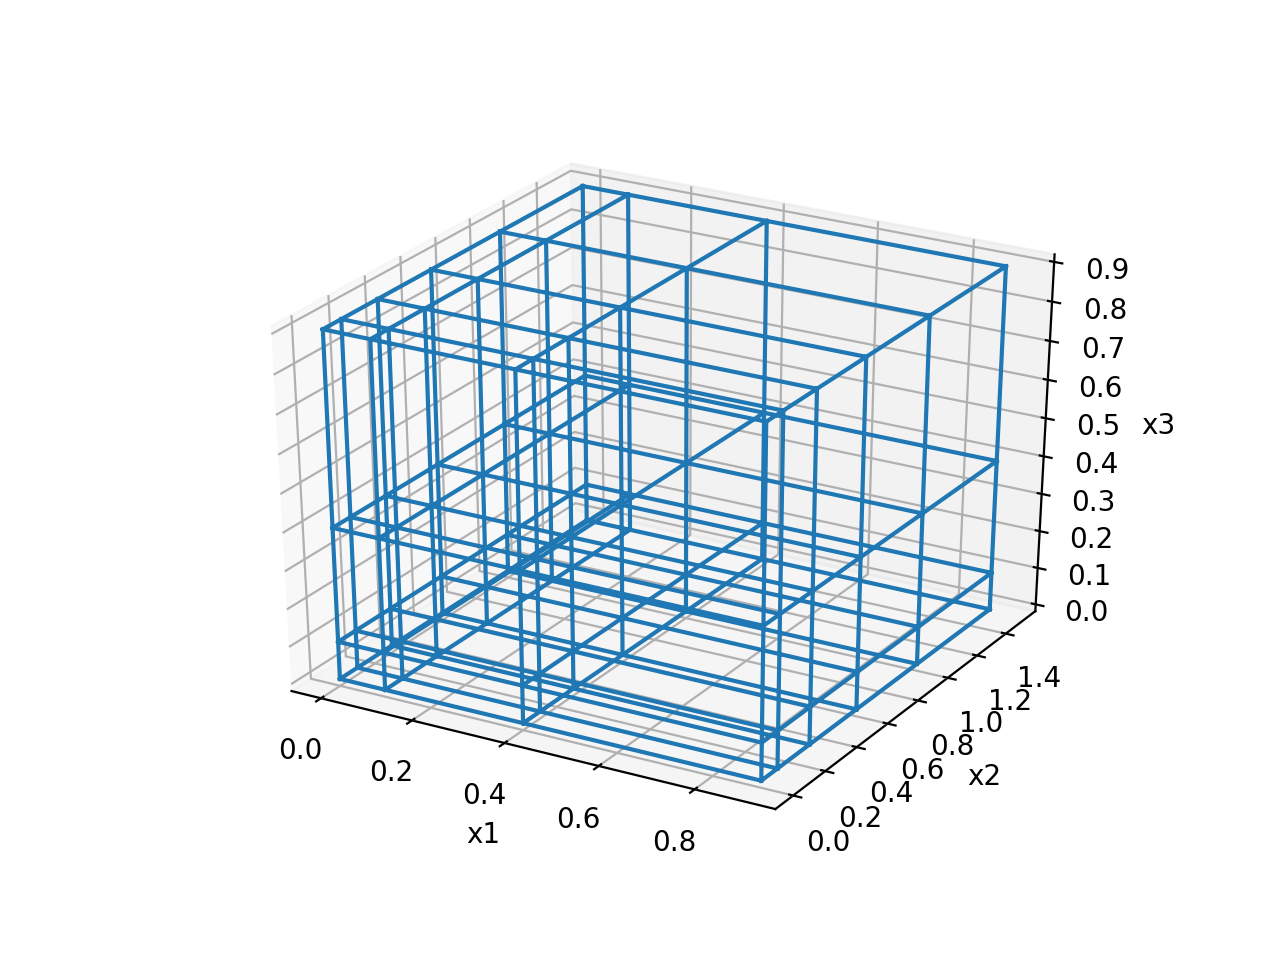

In [2]:
# Create a simple TensorMesh
h1 = np.linspace(.1, .5, 3)
h2 = np.linspace(.1, .5, 5)
h3 = np.linspace(.1, .5, 3)
mesh = discretize.TensorMesh([h1, h2, h3])
mesh.plotGrid()

Now that we have a `TensorMesh` object, we can call the `toVTK()` method to yield the proper VTK data object.

In [3]:
# Get a VTK data object
mesh.toVTK()

# or save this mesh to a VTK file
#mesh.writeVTK('sample_mesh')

(vtkCommonDataModelPython.vtkRectilinearGrid)0xb23732ae0

An additional feature added in [SimPEG/discretize#114](https://github.com/simpeg/discretize/pull/114) is the ability to specify rotated reference frames for any given mesh object. Let's rotate our reference frame and then convert the mesh to a VTK data object. Note that we no longer have a `vtkRectilinearGrid` but a `vtkStructuredGrid` due to having that `TensorMesh` rotated off of the traditional reference frame (traditional being <1,0,0>, <0,1,0>, <0,0,1>).

In [4]:
# Defined a rotated reference frame
mesh.axis_u = (1,-1,0)
mesh.axis_v = (-1,-1,0)
mesh.axis_w = (0,0,1)

# Check that the referenc fram is valid
mesh._validate_orientation()

# At this time, the grid code in discretize is not updated to plot the rotated grid

True

In [5]:
# Yield the rotated vtkStructuredGrid
mesh.toVTK()

# or write it out to a VTK format
#mesh.writeVTK('sample_rotated')

(vtkCommonDataModelPython.vtkStructuredGrid)0xb23732ce8

Here is a rendering of these two meshes to demonstrate the rotation:
    
![rotated](./images/vtk-rotated-example.png)

## 3. Pairing discretize+PVGeo

In this example, we load a `discretize` 3D model and a topography surface that generally covers that model in space. We then use PVGeo to provide a boolean array to describe whether any given cell is above/below the topography surface for the mesh.

This is a fairly simple example... we want you to focus less on the specific task of extracting the topography and more on the idea that `discretize` and `PVGeo` are able to talk to eachother and share their processing results.

### The Data

Here we load in some data we'd like to process: the [**Laguna del Maule Bouguer Gravity**](http://docs.simpeg.xyz/content/examples/04-grav/plot_laguna_del_maule_inversion.html#sphx-glr-content-examples-04-grav-plot-laguna-del-maule-inversion-py) example from the SimPEG docs.

This data scene is was produced from the [Laguna del Maule Bouguer Gravity](http://docs.simpeg.xyz/content/examples/04-grav/plot_laguna_del_maule_inversion.html#sphx-glr-content-examples-04-grav-plot-laguna-del-maule-inversion-py) example provided by [Craig Miller](https://github.com/craigmillernz) (Maule volcanic field, Chile. Refer to Miller et al 2016 EPSL for full details.)

The rendering below shows several data sets and a model integrated together:

* Point Data: the Bouguer gravity anomalies
* Topography Surface
* Inverted Model: The model has been both sliced and thresholded for low values


This rendering was created in ParaView using file I/O methods in PVGeo for UBC fomrats and general VTK filters available in ParaView. A ParaView state file is included in the data directory to recreate this scene.

![scene](./images/craig-example.png)

In [6]:
#!head data/Craig-Chile/LdM_topo.topo

In [7]:
#!head data/Craig-Chile/craig_chile.msh

Let's load the data files using a mixture of `discretize` and `PVGeo` for now to demo how PVGeo and discretize can talk to eachother.

<IPython.core.display.Javascript object>


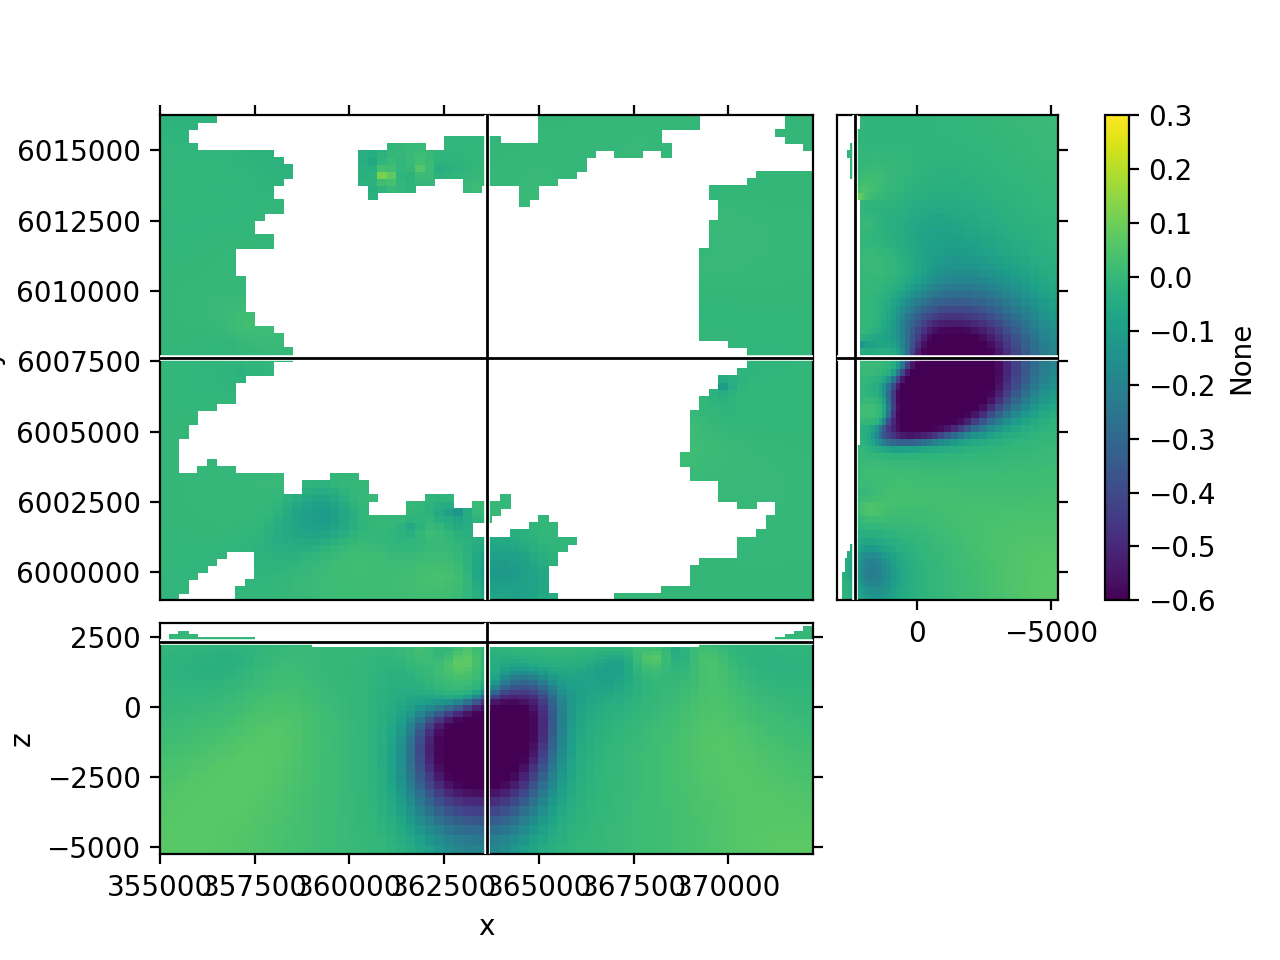

In [8]:
# Load the TensorMesh and some already processed model data 
mesh = discretize.TensorMesh.readUBC('craig_chile.msh', directory='data/Craig-Chile')
models = {'lpout': mesh.readModelUBC(fileName='Lpout.mod', directory='data/Craig-Chile')}
mesh.plot_3d_slicer(v=models['lpout'], zslice=2350)

In [9]:
mesh.nC

190440

### Process the Data

Now let's use the mesh from `discretize` and the topo surface in `PVGeo` to create a model array that describes whether or not any given cell in the model space is above/below the topogrpahy surface.

Also, let's ignore the fact the given model data is already accounts for topography (NaN values). Let's suppose for a moment that you are designing/inspecting your model space: Simply load the topography into a `vtkPolyData` object in `PVGeo` and feed it to the `ExtractTopography` algorithm.

Since the given topography file is in the [3D GIF Topography](https://giftoolscookbook.readthedocs.io/en/latest/content/fileFormats/topoGIF3Dfile.html) format, we can use the `PVGeo.ubc.TopoReader` file reader to read the file and automatically construct the `vtkPolyData`

In [10]:
# Load topography data using PVGeo
topo = PVGeo.ubc.TopoReader().Apply('data/Craig-Chile/LdM_topo.topo')
topo

(vtkCommonDataModelPython.vtkPolyData)0xb23a91188

In [11]:
# Call the ExtractTopography algorithm and have it apply on the 
#    discretize mesh and the topography
extracted = PVGeo.grids.ExtractTopography().Apply(mesh.toVTK(), topo)

In [12]:
active = PVGeo.getArray(extracted, 'Extracted')

In [13]:
models['active'] = active

<IPython.core.display.Javascript object>


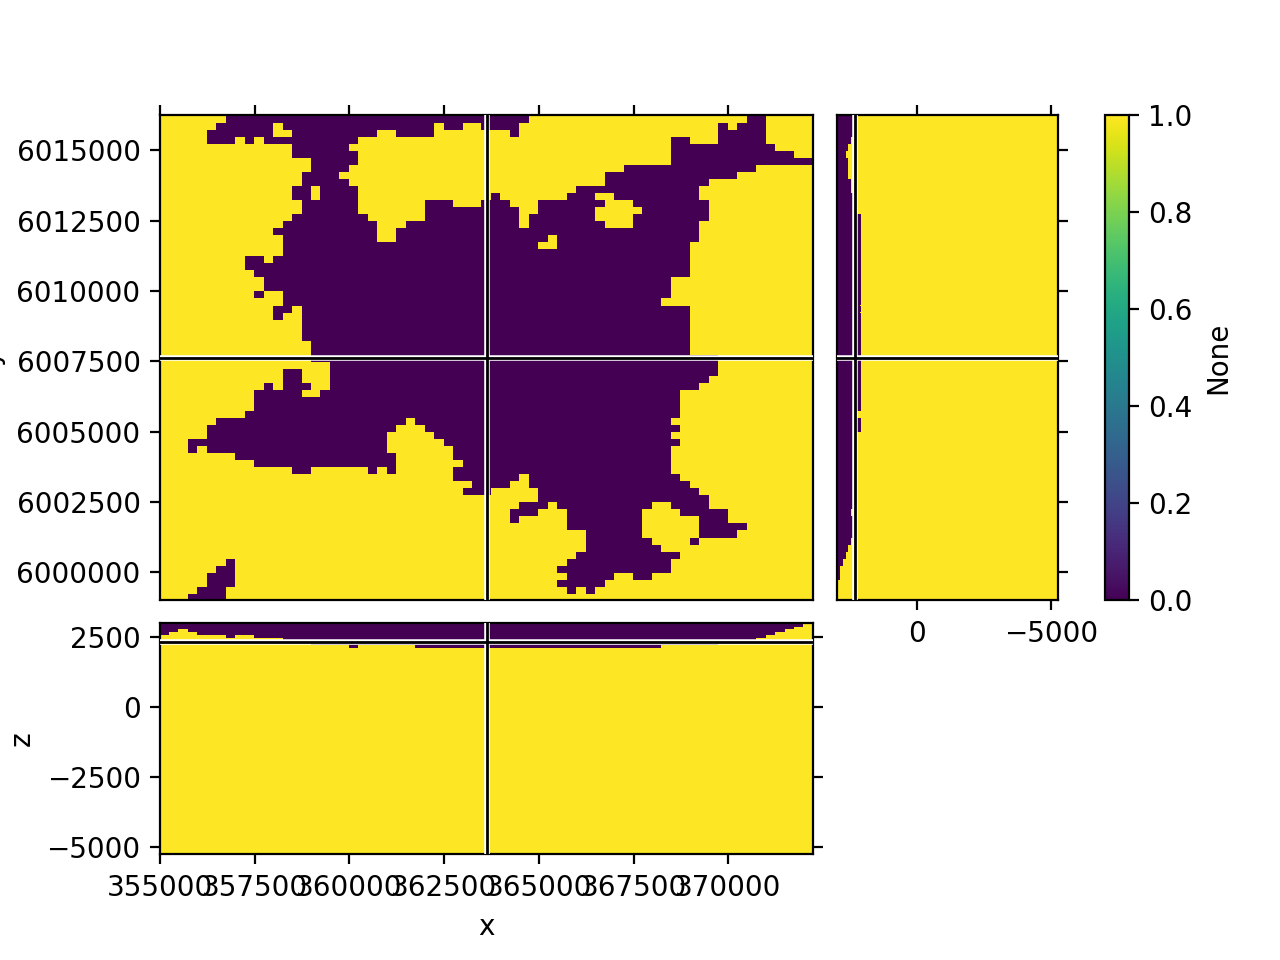

In [14]:
mesh.plot_3d_slicer(v=models['active'], zslice=2350)

### What about using a VTK algorthm?

Easy! Simply pass the VTK object to the VTK algorithm and use PVGeo's top level functions to yield the output in NumPy or Pandas friendly data structures!

<IPython.core.display.Javascript object>


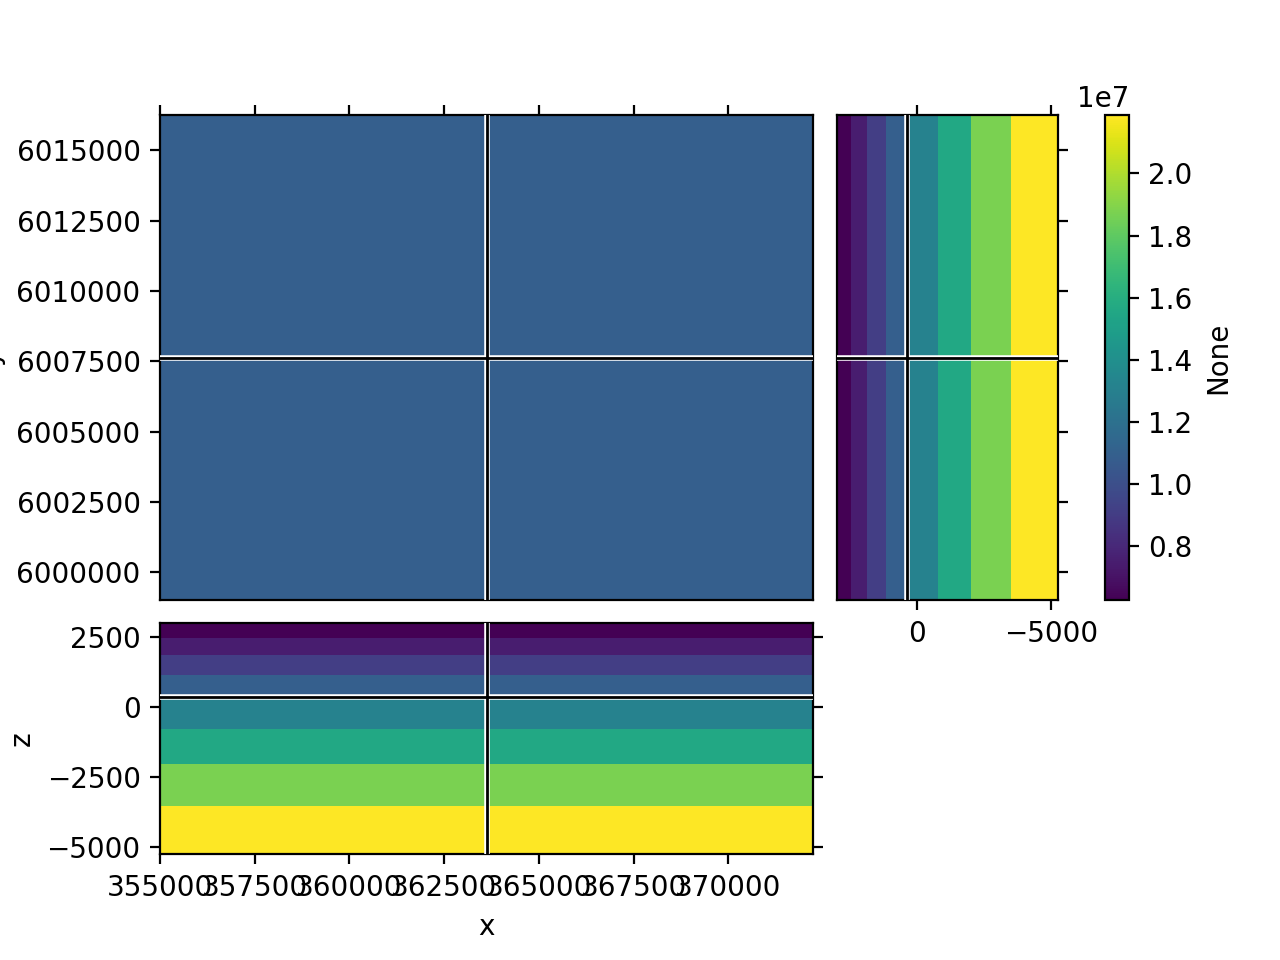

In [15]:
# Instantiate your algorithm
alg = vtk.vtkCellSizeFilter()
# Set the inputs
alg.SetInputDataObject(mesh.toVTK(models=models))
# Run the algorithm
alg.Update()
# Yield the output on the 0th port
out = alg.GetOutputDataObject(0)

# Get the face counts via PVGeo
counts = PVGeo.getArray(out, 'Volume')
# Use that arry to plot up the results!
mesh.plot_3d_slicer(counts)

## 4. Now What?

There are tons of awesome algorithms in ParaView/VTK and PVGeo that you could use to integrate datasets and produce meaningful visualizations. At this time, using those algorithms in a standard Python environment doesn't really make sense... They should be used directly in ParaView or `pvpython` to create visualizations until we have a stable toolset for interactive VTK visualizations in Jupyter Notebooks.

Note that the new VTK interface in `discretize` enables PVGeo to build an interface for `discretize` directly in [ParaView](https://paraview.org).

Use the UBC suite in PVGeo which has I/O functionality for `discretize` to create compelling 3D visualizations of all your data!

Some algorithms that might be of interest to you:

- [Extract Topography](http://pvgeo.org/examples/grids/extract-topography/): Use a topography surface to add an active cells field to an input dataset
- [Create Rectilinear Grid](http://pvgeo.org/examples/model-building/create-rectilinear-grid/) : Create a rectilinear grid / tensor mesh (`vtkRectilinearGrid`)
- [The UBC suite in PVGeo](http://pvgeo.org/examples/contents/#ubc-mesh-tools): Contains file I/O for TensorMeshes, TreeMeshes, and time series model data as well as file readers for general data formats like Grav/Mag observations or topography surfaces. The status of the UBC suite can be found on [OpenGeoVis/PVGeo#28](https://github.com/OpenGeoVis/PVGeo/issues/28).
- [Many Slices Along Axis](http://pvgeo.org/examples/filters-general/many-slices-along-axis/): Generate N slices of a dataset along a specified axis


